# LRFinder

### Data Processing

As always, we'll start by importing all the necessary modules. We have a few new imports here:
- `lr_scheduler` for using the one cycle learning rate scheduler
- `namedtuple` for handling ResNet configurations
- `os` and `shutil` for handling custom datasets

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torch.optim.lr_scheduler as lr_scheduler
#from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [19]:
print( torch.cuda.is_available() )

True


# Define resnet for CIFAR10

we'll first show how to create the configurations for the ResNet models.

Instead of using a simple list, like we did the for the VGG model in the previous notebook, we'll use a `namedtuple`. This will store: the block class, the number of blocks in each layer, and the number of channels in each layer.

In [20]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

The ResNet paper also covers variants specifically for the CIFAR10/100 datasets which we'll very briefly cover here. The code for them is adapted from [this](https://github.com/akamaster/pytorch_resnet_cifar10) repository.

<font color=red>The initial convolutional layer has smaller filter size, lower stride and less padding, and is not followed by a pooling layer. It also only has 3 layers, instead of 4, and has its own type of block.</font>

One requirement is that the number of channels for each layer has to be exactly double that of the previous layer - this is checked by the second `assert` statement.

In [21]:
class CIFARResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, layers, channels = config
        self.in_channels = channels[0]
            
        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, layers[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, layers[2], channels[2], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(channels, channels))

        self.in_channels = channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x
        #return x, h

The `CIFARBasicBlock` is similar to the standard `BasicBlock`, the only difference is in the downsampling residual connection.

The [paper](https://arxiv.org/abs/1512.03385) states that the ResNet models for CIFAR use a downsampling connection that uses "zero padding" and "all shortcuts are parameter free". We achieve this by using an `Identity` module, which is initialized with a function and applies that function when called.

For the function, we first slice the input with `x[:, :, ::2, ::2]`. This removes every other row and column in the image - downsampling it by simply throwing away pixels - whilst keeping the number of channels (depth) the same.

![](./../assets/resnet-pad.png)

We then double the number of channels with zeros using `pad`, which adds half the padding on to the front of the depth dimension, and half to the back.

In [22]:
class Identity(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
        
    def forward(self, x):
        return self.f(x)
        

class CIFARBasicBlock(nn.Module):
        
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            identity_fn = lambda x : F.pad(x[:, :, ::2, ::2], 
                                           [0, 0, 0, 0, in_channels // 2, in_channels // 2])
            downsample = Identity(identity_fn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                                
        x += i
        x = self.relu(x)
        
        return x

Below are the configurations for the CIFAR ResNet models. 

Similar to previous ResNet models, the `channels` do not change across configurations, just the number of blocks in each layer.

We can use the configurations to get the actual models as:

```python
ciafar_resnet_20 = CIFARResNet(cifar_resnet20_config, output_dim)
ciafar_resnet_32 = CIFARResNet(cifar_resnet32_config, output_dim)
ciafar_resnet_44 = CIFARResNet(cifar_resnet44_config, output_dim)
```

In [23]:
cifar_resnet20_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [3, 3, 3],
                                     channels = [16, 32, 64])

cifar_resnet32_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [5, 5, 5],
                                     channels = [16, 32, 64])

cifar_resnet44_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [7, 7, 7],
                                     channels = [16, 32, 64])

cifar_resnet56_config = ResNetConfig(block = CIFARBasicBlock,
                                     n_blocks = [9, 9, 9],
                                     channels = [16, 32, 64])

cifar_resnet110_config = ResNetConfig(block = CIFARBasicBlock,
                                      n_blocks = [18, 18, 18],
                                      channels = [16, 32, 64])

cifar_resnet1202_config = ResNetConfig(block = CIFARBasicBlock,
                                       n_blocks = [20, 20, 20],
                                       channels = [16, 32, 64])

## CIFAR10 example with ResNet56

This example demonstrates the usage of `LRFinder` with a ResNet56 on the Cifar10 dataset.

In [24]:
%matplotlib inline

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
#import cifar10_resnet as rc10

try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    #sys.path.insert(0, '..')
    sys.path.insert(0, './')
    from torch_lr_finder import LRFinder

### Loading CIFAR10

In [25]:
cifar_pwd = "./../data"
batch_size= 256

In [26]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root=cifar_pwd, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = CIFAR10(root=cifar_pwd, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [27]:
#model = rc10.resnet56()
OUTPUT_DIM = 10
model = CIFARResNet(cifar_resnet56_config, OUTPUT_DIM)

Show resnet56 structure.

In [28]:
print(model)

CIFARResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CIFARBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): CIFARBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Ba

## Training loss (fastai)

This learning rate test range follows the same procedure used by fastai. The model is trained for `num_iter` iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to `end_lr`. The increase can be linear (`step_mode="linear"`) or exponential (`step_mode="exp"`); linear provides good results for small ranges while exponential is recommended for larger ranges.

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **training** loss.

LR suggestion: steepest gradient
Suggested LR: 1.23E-03


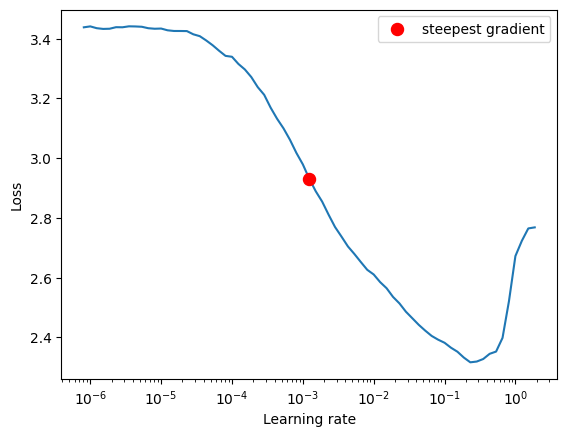

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.0012328467394420656)

In [30]:
lr_finder.plot()

To restore the model and optimizer to their initial state use the `reset()` method.

In [31]:
lr_finder.reset()

## Validation loss (Leslie N. Smith)

If a dataloader is passed to `LRFinder.range_test()` through the `val_loader` parameter the model is evaluated on that dataset after each iteration. The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. The disadvantage is that it takes significantly longer to run.

This version of the learning rate range test is described in [Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith](https://arxiv.org/abs/1506.01186).

In [ ]:
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=100, num_iter=100, step_mode="exp")

Note that the loss in the loss vs. learning rate plot is the **evaluation** loss.

In [ ]:
lr_finder.plot(skip_end=0)

To restore the model and optimizer to their initial state use the `reset()` method.

In [ ]:
lr_finder.reset()